In [0]:
import pandas as pd
import numpy as np
#import pydicom
import glob
import os
import pandas as pd
import numpy as np
#import pydicom
#import glob
#import os
import re
from pathlib import Path
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
#import re
#from pathlib import Path

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout,Input,Average,Conv2DTranspose,SeparableConv2D,dot,UpSampling2D,Add, Flatten,Concatenate,Multiply,Conv2D, MaxPooling2D,Activation,AveragePooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint 

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50,VGG19,VGG16,DenseNet121,DenseNet169,InceptionResNetV2

import numpy as np
from skimage.morphology import square,binary_erosion,binary_dilation,binary_opening,binary_closing
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from keras.initializers import RandomNormal
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras import regularizers
from keras.models import Model

Using TensorFlow backend.


In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive',force_remount=True)
root_dir='/content/gdrive/My Drive/'
base_dir=root_dir+'Colab Notebooks/'

Mounted at /content/gdrive


In [0]:
import tensorflow as tf


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:

Y=np.load(root_dir+'DATASET/Y_2D.npy')
Y.shape


(5862, 512, 512)

In [0]:

def normalize(img):
    arr = img.copy().astype(np.float)
    M = np.float(np.max(img))
    if M != 0:
        arr *= 1./M
    return arr
    
def cropimread(crop, xcrop, ycrop):
    ysize = crop.shape[0]
    xsize = crop.shape[1]
    xoff = (xsize - xcrop) // 2
    yoff = (ysize - ycrop) // 2
    crop= crop[yoff:-yoff,xoff:-xoff]
    return crop

In [0]:
Yimg = []
for i in range(Y.shape[0]):
    HH = cropimread(Y[i,:,:], 224,224)
    #HH = normalize(HH)
    #HH = resize(HH, (320, 320))
    Yimg.append(HH)

Y = []
Yimg = np.asarray(Yimg)


In [0]:
from keras.utils import to_categorical

In [0]:
ytemp = to_categorical(Yimg,6,dtype='int16')

In [0]:
ytemp.shape

(5862, 224, 224, 6)

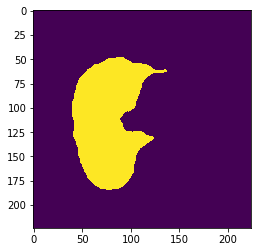

In [0]:
plt.imshow(ytemp[72,:,:,5])

In [0]:

X=np.load(root_dir+'DATASET/X_2D.npy')
X.shape


(5862, 512, 512)

In [0]:
Ximg = []
from skimage.transform import resize
for i in range(X.shape[0]):
    HH = cropimread(X[i,:,:], 224,224)
    HH = normalize(HH)
    #HH = resize(HH, (320, 320))
    Ximg.append(HH)

X = []
Ximg = np.asarray(Ximg)


In [0]:
#Ximg = np.delete(Ximg,np.s_[141:306],axis=0)

In [0]:
Ximg.shape

(5862, 224, 224)

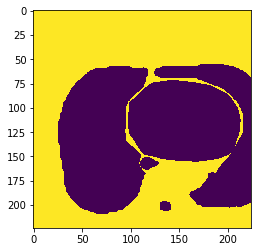

In [0]:
plt.imshow(ytemp[200,:,:,0])

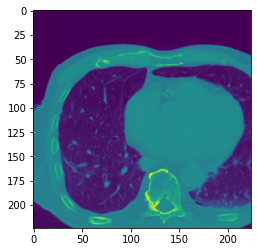

In [0]:
plt.imshow(Ximg[200])

In [0]:
Yimg = ytemp
ytemp = []

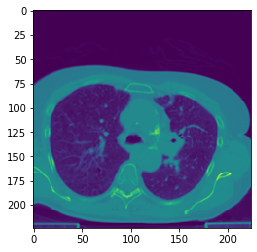

In [0]:
plt.imshow(Ximg[1780,:,:])

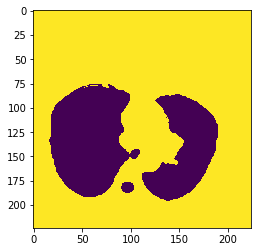

In [0]:
plt.imshow(Yimg[1780,:,:,0])

In [0]:
Ximg[72,:,:]

array([[-0.97751711, -0.97751711, -0.97653959, ..., -0.97751711,
        -0.97751711, -0.97751711],
       [-0.97751711, -0.97751711, -0.97751711, ..., -0.97751711,
        -0.97751711, -0.97751711],
       [-0.97751711, -0.97751711, -0.97751711, ..., -0.97751711,
        -0.97751711, -0.97751711],
       ...,
       [-0.91006843, -0.90811339, -0.91104594, ..., -0.91006843,
        -0.91397849, -0.91300098],
       [-0.89247312, -0.89345064, -0.89442815, ..., -0.89833822,
        -0.90029326, -0.90127077],
       [-0.85826002, -0.86021505, -0.85826002, ..., -0.87487781,
        -0.87585533, -0.87683284]])

In [0]:
Yimg.shape

(5862, 224, 224, 6)

In [0]:
Ximg = Ximg[:,:,:,None]


X_train, X_test, y_train, y_test = train_test_split(Ximg, Yimg, random_state=42, test_size=0.2)
# def dataloader(x,y,bs):
#     indices = np.arange(x.shape[0])
#     np.random.shuffle(indices)
    
#     for i in range(0,len(indices),bs):
#         yield x[i:i+bs] , y[i:i+bs]
    

In [0]:
Ximg = []
Yimg = []
X_train.shape

# X_train = X_train[:,:,:,None]
# y_train = y_train[:,:,:,None]

# X_test = X_test[:,:,:,None]
# y_test = y_test[:,:,:,None]

(4689, 224, 224, 1)

In [0]:


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return K.sum(score)

def weighted_dice_loss(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)


# def atrous_spatial_pyramid_pooling(net, depth=256, reuse=None):
#     # apply global average pooling
#     image_level_features = GlobalAveragePooling2D()(net)
#     image_level_features = Conv2D(depth, (1, 1), scope="image_level_conv_1x1")(image_level_features)
#     image_level_features = tf.image.resize_bilinear(image_level_features, (feature_map_size[1], feature_map_size[2]))
    
#     at_pool1x1 = Conv2D(net, depth, (1, 1), scope="conv_1x1_0")(net)

#     at_pool3x3_1 = Conv2D(net, depth, (3, 3), scope="conv_3x3_1", rate=6)(net)

#     at_pool3x3_2 = Conv2D(net, depth, (3, 3), scope="conv_3x3_2", rate=12)(net)

#     at_pool3x3_3 = Conv2D(depth, (3, 3), scope="conv_3x3_3", rate=18)(net)

#     net = concatenate((image_level_features, at_pool1x1, at_pool3x3_1, at_pool3x3_2, at_pool3x3_3), axis=3,
#                         name="concat")
#     net = Conv2D(depth, (1, 1), scope="conv_1x1_output")(net)
#     return net



In [0]:
# def conv_2d(input_layer,n_filters,kernel,padding='same',strides=(1,1)):
#     layer=Conv2D(n_filters,kernel,padding=padding,strides=strides,W_regularizer=l2(0.0004))(input_layer)
#     layer=BatchNormalization(axis=-1,momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(layer)
#     return LeakyReLU(alpha=0.1)(layer)

In [0]:
def Attention_B(X, G, k):
    FL = int(X.shape[-1])
    init = RandomNormal(stddev=0.02)
    theta = Conv2D(k,(2,2), strides = (2,2), padding='same')(X)
    Phi = Conv2D(k, (1,1), strides =(1,1), padding='same', use_bias=True)(G)
    
    ADD = Add()([theta, Phi])
    
    #ADD = LeakyReLU(alpha=0.1)(ADD)
    ADD = Activation('relu')(ADD)
    
    #Psi = Conv2D(FL,(1,1), strides = (1,1), padding="same",kernel_initializer=init)(ADD)
    Psi = Conv2D(1,(1,1), strides = (1,1), padding="same",kernel_initializer=init)(ADD)
    Psi = Activation('sigmoid')(Psi)
    Up = Conv2DTranspose(1, (2,2), strides=(2, 2), padding='valid')(Psi)
    
    #Psi = Activation('tanh')(Psi)
    
    #Up = Conv2DTranspose(FL, (2,2), strides=(2, 2), padding='valid')(Psi)
    
    Final = Multiply()([X, Up])
    Final = Conv2D(1, (1,1), strides = (1,1), padding="same",kernel_initializer=init)(Final)
    #Final = Conv2D(FL, (1,1), strides = (1,1), padding="same",kernel_initializer=init)(Final)
    Final = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-5)(Final)
    print(Final.shape)
    return Final


In [0]:
def Unet3(input_shape,n_filters,kernel=(3,3),strides=(1,1),pad='same'):
    x = input_shape
    conv1 = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(input_shape)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    
    conv2 = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(conv1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 =  LeakyReLU(alpha=0.1)(conv2)
    
    x = Conv2D(n_filters,kernel_size = (1,1),strides = (1,1),padding = 'same')(x)
    
    return Add()([x,conv2])
    


In [0]:
def Up3(input1,input2,kernel=(3,3),stride=(1,1), pad='same'):
    #up = UpSampling2D(2)(input2)
    up = Conv2DTranspose(int(input1.shape[-1]),(1, 1), strides=(2, 2), padding='same')(input2)
    #assert up.shape == input1.shape
    up = Concatenate()([up,input1])
    
    return Unet3(up,int(input1.shape[-1]),kernel,stride,pad)
  

In [0]:



def gatingSig(input_shape,n_filters,kernel=(1,1),strides=(1,1),pad='same'):
    conv = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(input_shape)
    conv = BatchNormalization(axis=-1)(conv)
    return LeakyReLU(alpha=0.1)(conv)

def DSup(x, var):
    d = Conv2D(1,(1,1), strides=(1,1), padding = "same")(x)
    d = UpSampling2D(var)(d)
    return d

def DSup1(x, var):
    d = Conv2D(1,(2,2), strides=(2,2), padding = "same")(x)
    d = UpSampling2D(var)(d)
    return d

In [0]:
def Inception(Image):
    n_labels = 6
    feature_scale = 8
    #input_shape= Image.shape
    filters = [64, 128, 256, 512,1024]

    #filters = [int(x /feature_scale) for x in filters]
        
    inputs = Input(Image)
    conv1 = Unet3(inputs,filters[0])
    maxp1 = MaxPooling2D(2)(conv1)
    
    
    conv2 = Unet3(maxp1,filters[1])
    maxp2 = MaxPooling2D(2)(conv2)
          
      
    conv3 = Unet3(maxp2,filters[2])
    maxp3 = MaxPooling2D(2)(conv3)
        
    conv4 = Unet3(maxp3,filters[3])
    maxp4 = MaxPooling2D(2)(conv4)
        
    center = Unet3(maxp4,filters[4])
    gating = gatingSig(center,filters[4])
        
    D1 = Attention_B(conv4,gating,filters[3])
    D2 = Up3(D1,gating)
        
    D3 = Attention_B(conv3,D2,filters[2])
    D4 = Up3(D3,D2)
    
            
    D5 = Attention_B(conv2,D4,filters[1])
    D6 = Up3(D5,D4)
        
    D7 = Up3(conv1, D6)
        
    DS1 = Conv2D(n_labels,(1,1), strides=(1,1), padding="same",activation='softmax')(D7)
        
        
    #DS4 = DSup1(D4,8)
    
    #DS4 = Conv2D(1,(2,2), strides=(2,2), padding="same")(DS4)
        
    #DDD = Concatenate()([DS1, DS4])
        
        
    #DDD = Conv2D(1,(1,1),strides=(1,1),padding="same")(DDD)
        
    model = Model(inputs, DS1)
    return model

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
X_train.shape

(4689, 224, 224, 1)

In [0]:
from keras.regularizers import l2
from keras import backend as K

G = Inception(X_train[0].shape)














(?, 28, 28, 1)
(?, 56, 56, 1)
(?, 112, 112, 1)


In [0]:
G.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 224, 224, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:

import tensorflow as tf
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
     


    

def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

#opt = Adam(lr=1e-2)
G.compile(loss= 'categorical_crossentropy', optimizer="adam", metrics=["accuracy",dice_coefficient])

In [0]:
import math

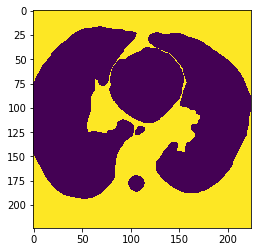

In [0]:
plt.imshow(y_train[1930,:,:,0])

In [0]:
weight_saver = ModelCheckpoint(root_dir+'DATASET/Lung_multi_v1.h5', monitor = 'val_dice_coefficient', save_best_only = True, save_weights_only =True )

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return (0.001 *math.exp(0.1 * (10 - epoch)))

callback = keras.callbacks.LearningRateScheduler(scheduler)


class TrainingPlot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Before plotting ensure at least 2 epochs have passed
        if epoch >=0:
            
            # Clear the previous plot
            #clear_output(wait=True)
            img = y_test[73:75]
            img1 = y_train[1930:1932]
            
            gen_img = G.predict(X_test[73:75])
            gen_img1 = G.predict(X_train[1930:1932])
            
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            #plt.figure()
            plt.imshow(img[0,:,:,0],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,0] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
#             plt.imshow(img[0,:,:,1],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img[0,:,:,1] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
#             plt.imshow(img[0,:,:,2],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img[0,:,:,2] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
#             plt.imshow(img[0,:,:,3],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img[0,:,:,3] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
            
#             plt.imshow(img[0,:,:,4],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img[0,:,:,4] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
            
            plt.imshow(img1[0,:,:,0],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,0] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
#             plt.imshow(img1[0,:,:,1],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img1[0,:,:,1] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
#             plt.imshow(img1[0,:,:,2],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img1[0,:,:,2] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
#             plt.imshow(img1[0,:,:,3],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img1[0,:,:,3] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
#             plt.imshow(img1[0,:,:,4],cmap='gray',label = "Ground Truth")
#             plt.pause(0.01)
            
#             plt.imshow(gen_img1[0,:,:,4] ,cmap='gray', label = "predicted")
#             plt.pause(0.01)
            
            
plots = TrainingPlot()


In [0]:
#G.load_weights(root_dir+'DATASET/Lung_multi.h5')
init = 0

Train on 4689 samples, validate on 1173 samples
Epoch 1/25
4689/4689 [==============================] - 108s 23ms/step - loss: 0.5295 - acc: 0.8343 - dice_coefficient: 0.7590 - val_loss: 1.1568 - val_acc: 0.6687 - val_dice_coefficient: 0.6220


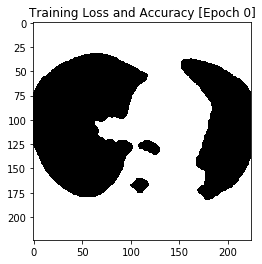

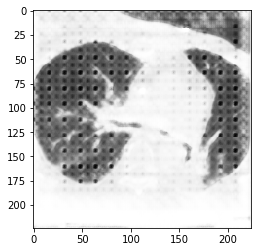

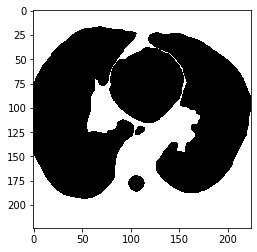

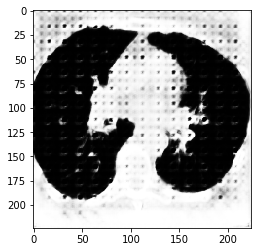

Epoch 2/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.3836 - acc: 0.8629 - dice_coefficient: 0.8185 - val_loss: 0.4904 - val_acc: 0.8453 - val_dice_coefficient: 0.8375


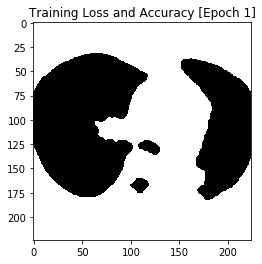

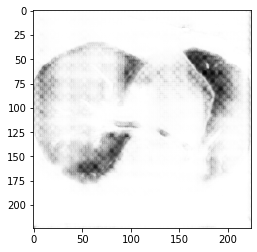

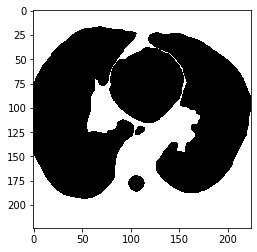

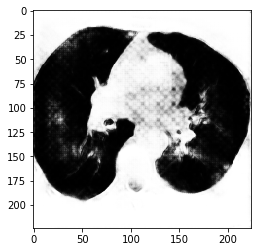

Epoch 3/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.3291 - acc: 0.8847 - dice_coefficient: 0.8422 - val_loss: 1.3103 - val_acc: 0.8193 - val_dice_coefficient: 0.8156


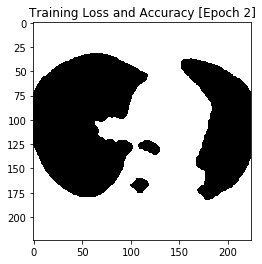

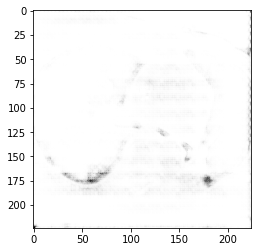

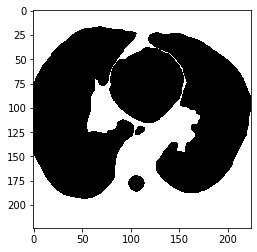

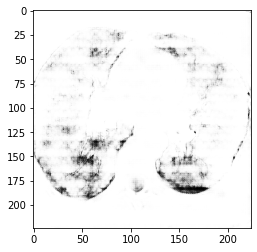

Epoch 4/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2993 - acc: 0.9025 - dice_coefficient: 0.8583 - val_loss: 0.3650 - val_acc: 0.8785 - val_dice_coefficient: 0.8492


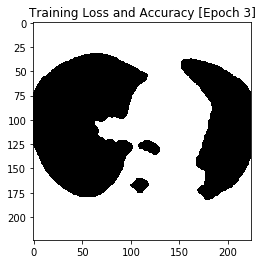

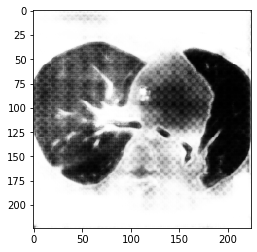

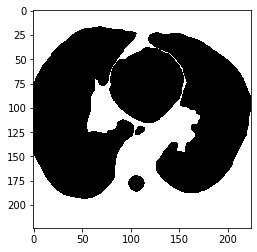

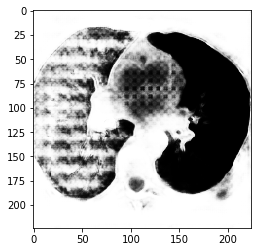

Epoch 5/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2840 - acc: 0.9061 - dice_coefficient: 0.8657 - val_loss: 0.2982 - val_acc: 0.9042 - val_dice_coefficient: 0.8741


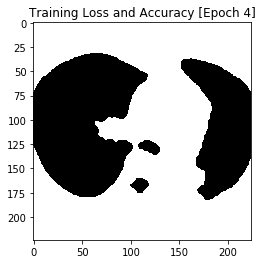

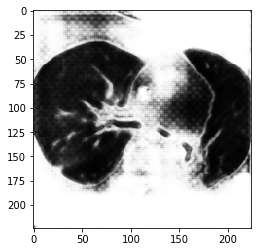

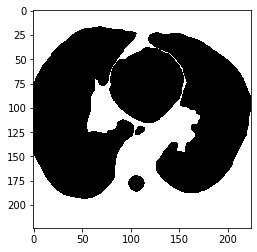

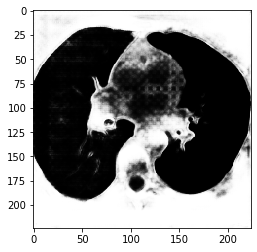

Epoch 6/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2627 - acc: 0.9130 - dice_coefficient: 0.8743 - val_loss: 0.3046 - val_acc: 0.9026 - val_dice_coefficient: 0.8580


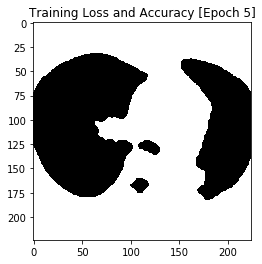

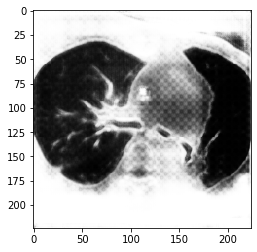

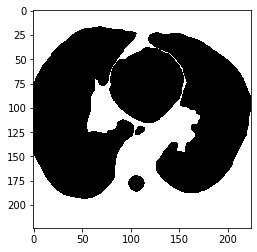

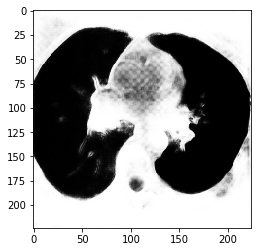

Epoch 7/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2604 - acc: 0.9138 - dice_coefficient: 0.8758 - val_loss: 0.2664 - val_acc: 0.9125 - val_dice_coefficient: 0.8767


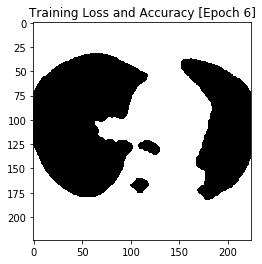

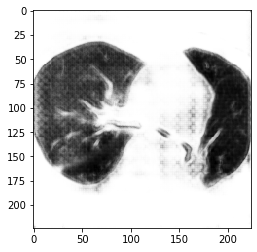

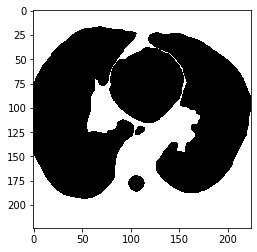

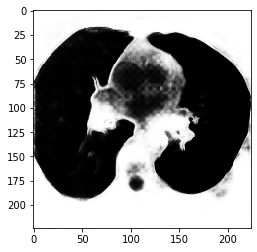

Epoch 8/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2511 - acc: 0.9160 - dice_coefficient: 0.8792 - val_loss: 0.2613 - val_acc: 0.9126 - val_dice_coefficient: 0.8842


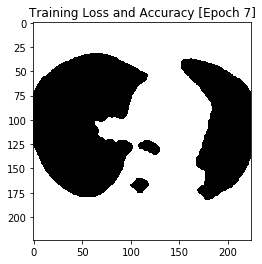

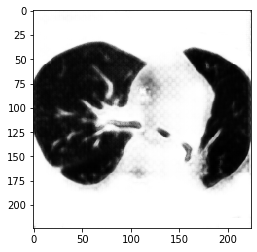

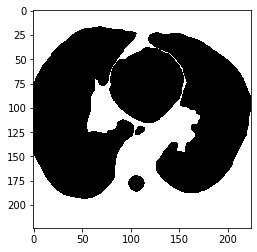

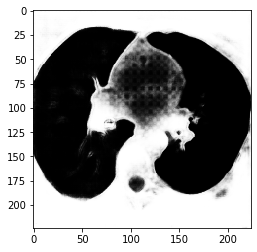

Epoch 9/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2379 - acc: 0.9196 - dice_coefficient: 0.8853 - val_loss: 0.2260 - val_acc: 0.9236 - val_dice_coefficient: 0.8920


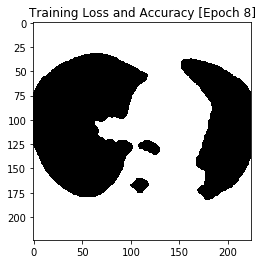

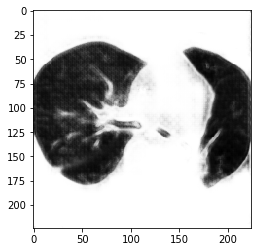

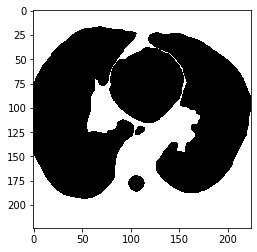

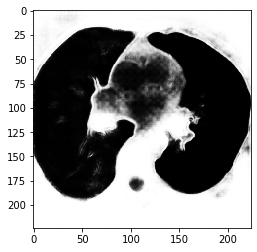

Epoch 10/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2327 - acc: 0.9204 - dice_coefficient: 0.8867 - val_loss: 0.2922 - val_acc: 0.8889 - val_dice_coefficient: 0.8668


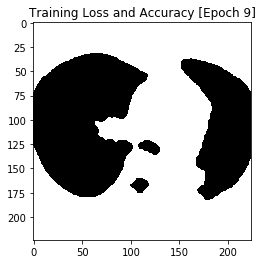

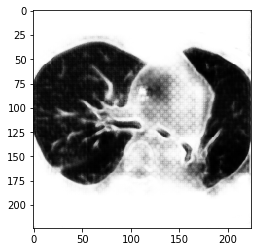

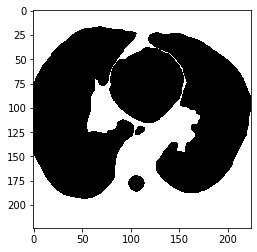

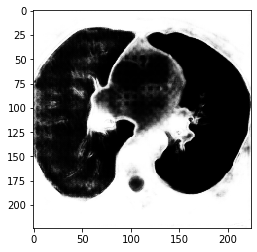

Epoch 11/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2231 - acc: 0.9235 - dice_coefficient: 0.8908 - val_loss: 0.2298 - val_acc: 0.9233 - val_dice_coefficient: 0.8960


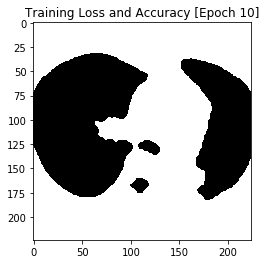

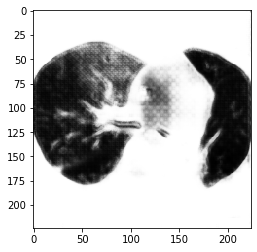

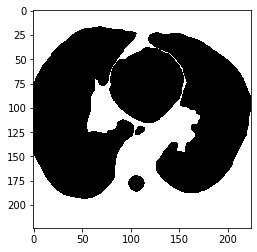

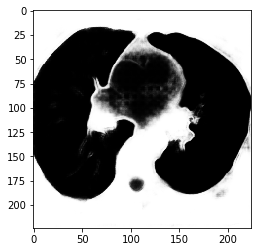

Epoch 12/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2168 - acc: 0.9247 - dice_coefficient: 0.8932 - val_loss: 0.2700 - val_acc: 0.9092 - val_dice_coefficient: 0.8861


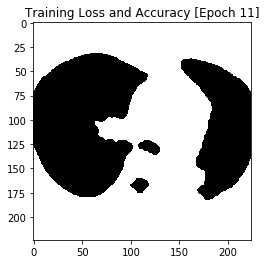

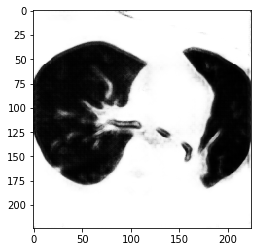

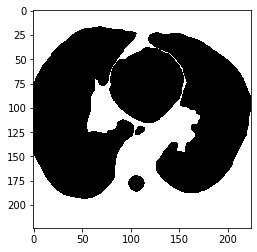

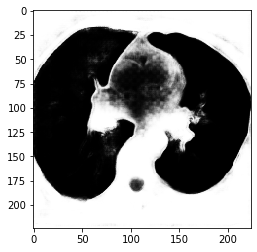

Epoch 13/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.2063 - acc: 0.9270 - dice_coefficient: 0.8974 - val_loss: 0.2320 - val_acc: 0.9115 - val_dice_coefficient: 0.8926


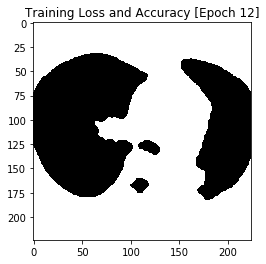

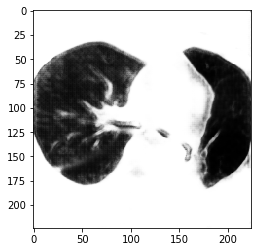

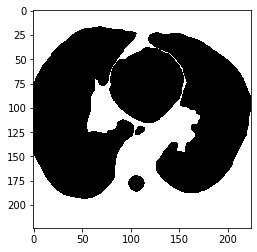

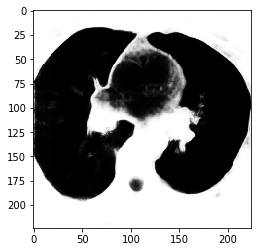

Epoch 14/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1972 - acc: 0.9298 - dice_coefficient: 0.9011 - val_loss: 0.2921 - val_acc: 0.9100 - val_dice_coefficient: 0.8552


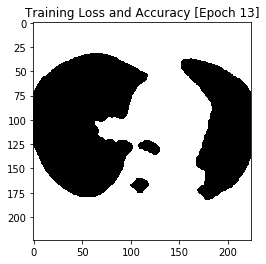

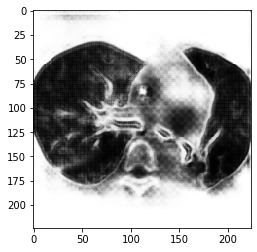

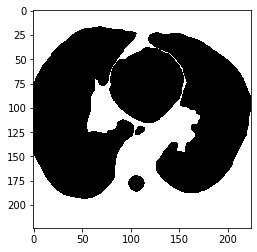

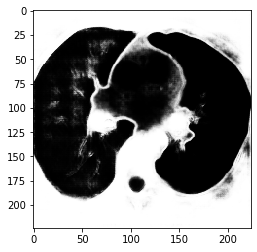

Epoch 15/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1896 - acc: 0.9320 - dice_coefficient: 0.9043 - val_loss: 0.3225 - val_acc: 0.8943 - val_dice_coefficient: 0.8793


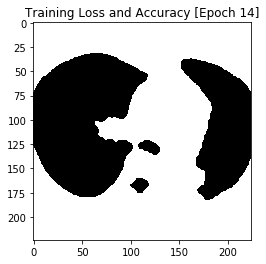

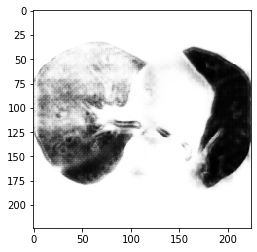

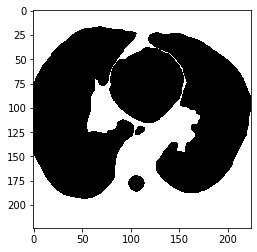

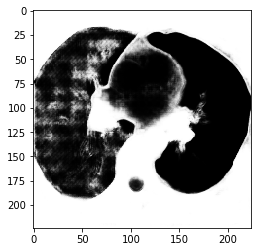

Epoch 16/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1815 - acc: 0.9357 - dice_coefficient: 0.9084 - val_loss: 0.2291 - val_acc: 0.9262 - val_dice_coefficient: 0.9074


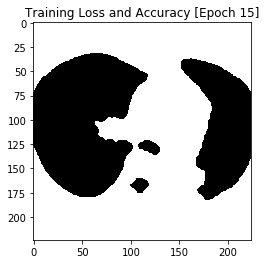

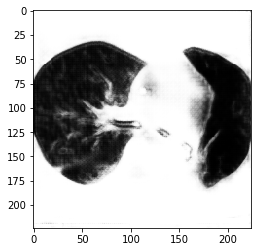

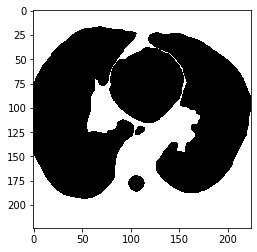

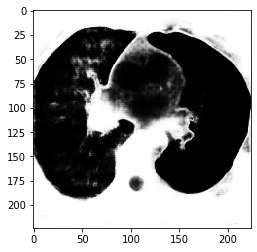

Epoch 17/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1751 - acc: 0.9397 - dice_coefficient: 0.9115 - val_loss: 0.2031 - val_acc: 0.9339 - val_dice_coefficient: 0.9078


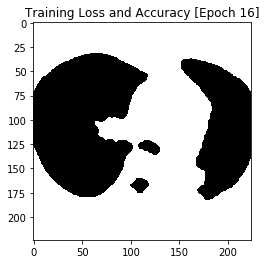

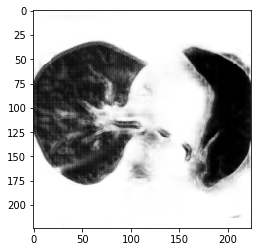

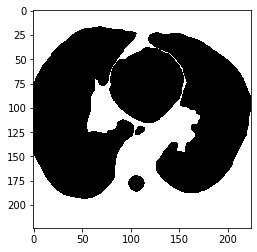

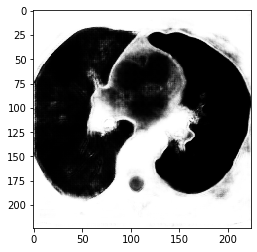

Epoch 18/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1589 - acc: 0.9458 - dice_coefficient: 0.9193 - val_loss: 0.2582 - val_acc: 0.9061 - val_dice_coefficient: 0.8977


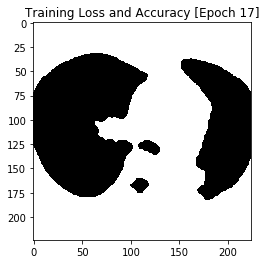

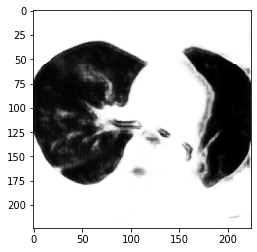

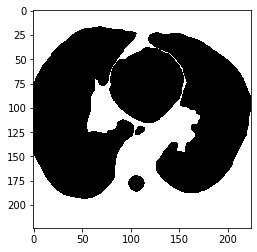

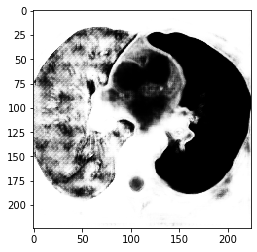

Epoch 19/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1550 - acc: 0.9478 - dice_coefficient: 0.9220 - val_loss: 0.2223 - val_acc: 0.9254 - val_dice_coefficient: 0.8964


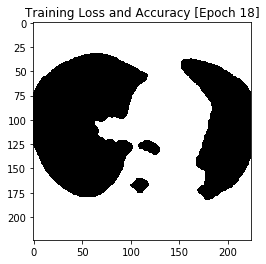

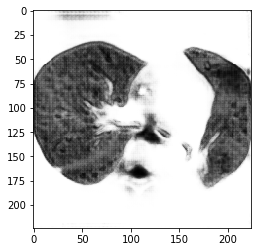

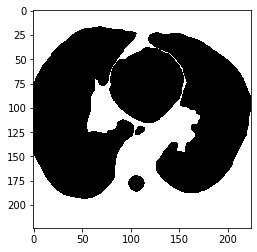

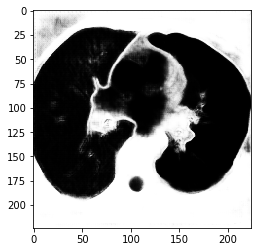

Epoch 20/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1461 - acc: 0.9511 - dice_coefficient: 0.9262 - val_loss: 0.1847 - val_acc: 0.9375 - val_dice_coefficient: 0.9178


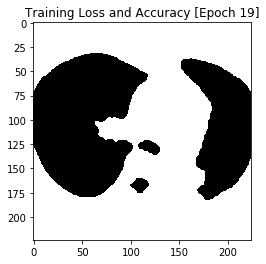

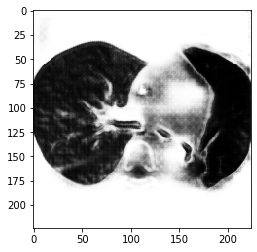

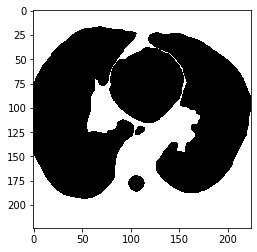

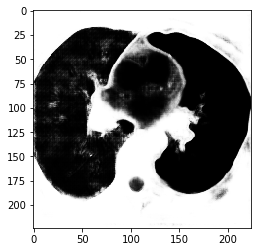

Epoch 21/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1272 - acc: 0.9574 - dice_coefficient: 0.9346 - val_loss: 0.2229 - val_acc: 0.9272 - val_dice_coefficient: 0.9114


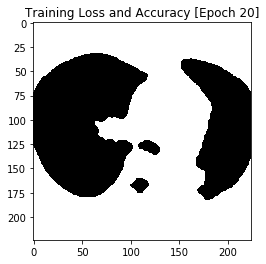

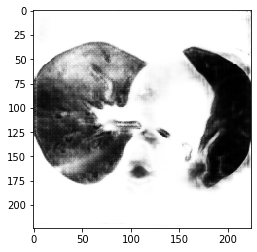

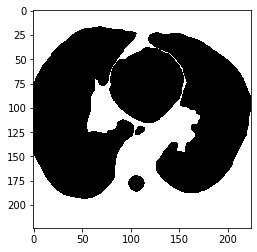

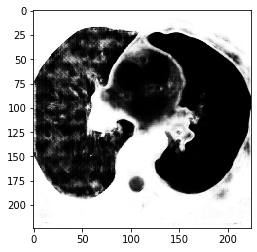

Epoch 22/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1161 - acc: 0.9610 - dice_coefficient: 0.9406 - val_loss: 0.2360 - val_acc: 0.9393 - val_dice_coefficient: 0.9264


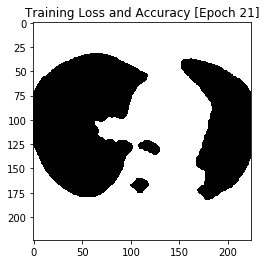

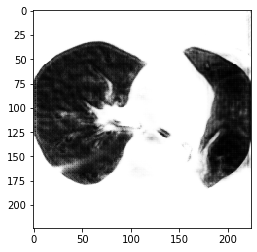

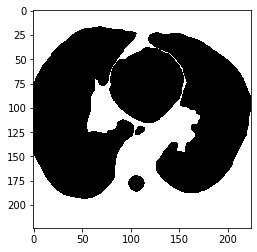

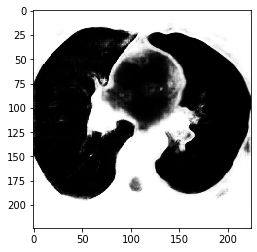

Epoch 23/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1138 - acc: 0.9615 - dice_coefficient: 0.9420 - val_loss: 0.1440 - val_acc: 0.9499 - val_dice_coefficient: 0.9314


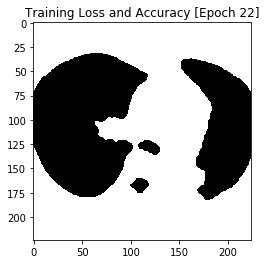

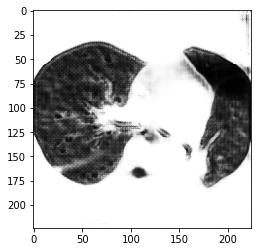

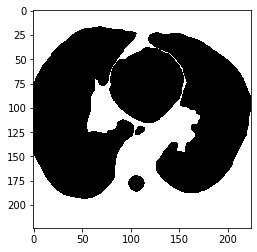

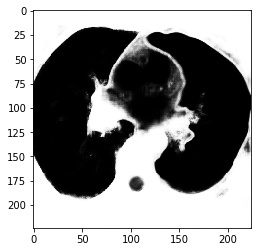

Epoch 24/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.1069 - acc: 0.9641 - dice_coefficient: 0.9455 - val_loss: 0.1601 - val_acc: 0.9418 - val_dice_coefficient: 0.9274


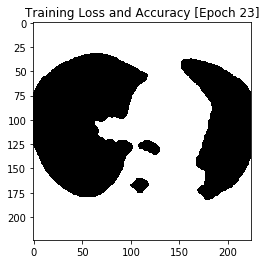

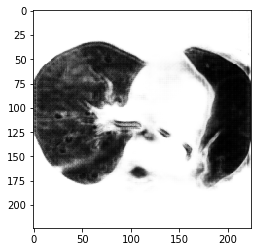

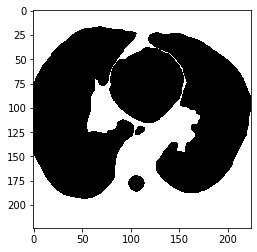

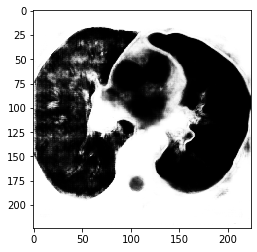

Epoch 25/25
4689/4689 [==============================] - 103s 22ms/step - loss: 0.0979 - acc: 0.9666 - dice_coefficient: 0.9493 - val_loss: 0.1427 - val_acc: 0.9522 - val_dice_coefficient: 0.9363


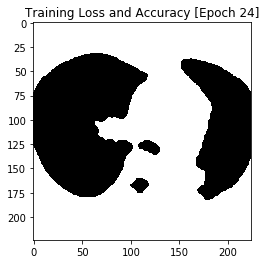

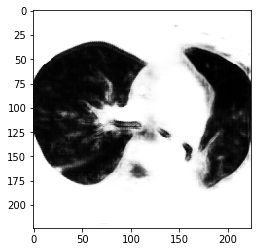

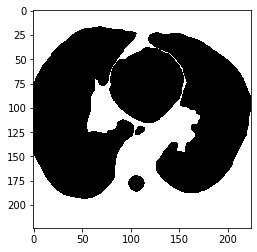

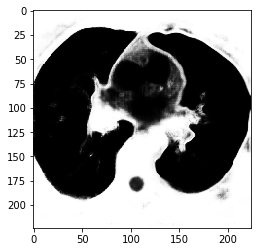

In [0]:
h =G.fit(X_train,y_train,batch_size = 32,epochs = 25, callbacks = [weight_saver,plots],validation_data=(X_test, y_test),initial_epoch=init)

In [0]:
gen_imgs = G.predict(X_test[500:700])


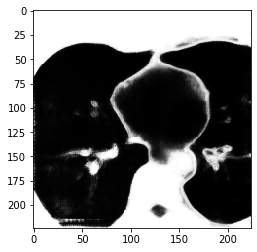

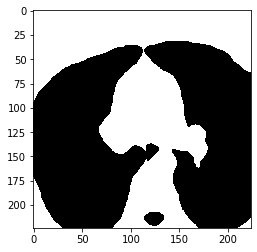

In [0]:
plt.imshow(gen_imgs[3,:,:,0], cmap='gray')
plt.pause(0.01)
plt.imshow(y_test[3,:,:,0], cmap = 'gray')
plt.pause(0.01)

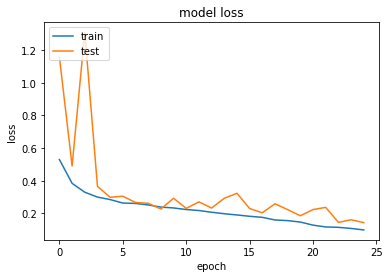

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
gen_imgs = G.predict(X_train[500:700])


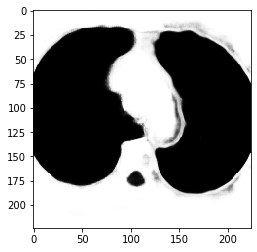

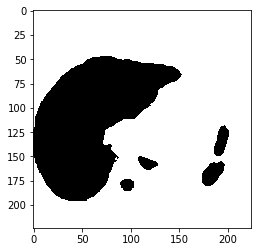

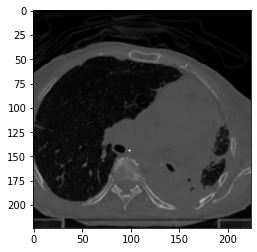

In [0]:
plt.imshow(gen_imgs[3,:,:,0], cmap='gray')
plt.pause(0.01)
plt.imshow(y_train[3,:,:,0], cmap = 'gray')
plt.pause(0.01)

plt.imshow(X_train[3,:,:,0], cmap = 'gray')
plt.pause(0.01)